In [101]:
import numpy as np
import matplotlib.pyplot as plt

from math import ceil, floor
import scipy.optimize._minimize as minimize

In [102]:
#checking the vaildity of the source plane map

import matplotlib.pyplot as plt
%matplotlib inline


# import the LensModel class #
from lenstronomy.LensModel.lens_model import LensModel

# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
kwargs_sie = {'theta_E': 100, 'e1':0, 'e2':0.4, 'center_x': 270, 'center_y': 310}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
x_grid, y_grid = np.meshgrid(np.linspace(0, size, size+1), np.linspace(0, size, size+1))
# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape) #(y,x)
alpha_y_2d = alpha_y.reshape(x_grid.shape) #(y,x)





32


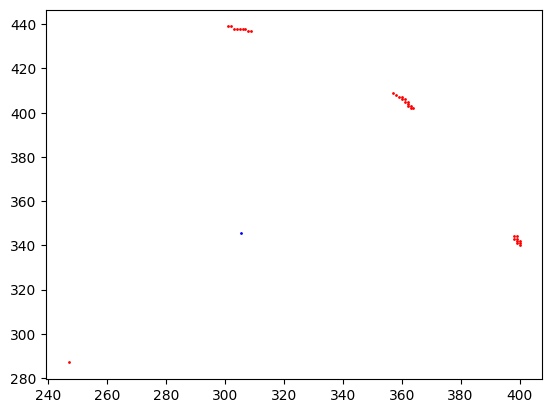

In [103]:
# Assuming alpha_y_2d and alpha_x_2d are defined and 'size' is known
coord = (305.5,345.4)
coord_x_r, coord_y_r = coord[0] % 1, coord[1] % 1
y_round, x_round = round(coord[1]), round(coord[0])

# Pre-calculate possible matching rounded values for efficiency
y_possible_rounds = {y_round, y_round - 1} if coord_y_r == 0.5 else {y_round}
x_possible_rounds = {x_round, x_round - 1} if coord_x_r == 0.5 else {x_round}

coordinates = []
n = 0

# Iterate over a pre-defined range, assuming alpha_y_2d and alpha_x_2d are indexed appropriately
for i in range(size):
    for j in range(size):
        ycoord, xcoord = i - alpha_y_2d[i, j], j - alpha_x_2d[i, j]
        if round(ycoord) in y_possible_rounds and round(xcoord) in x_possible_rounds:
            coordinates.append((j, i))  # (x, y)
            n += 1

plt.scatter([i[0] for i in coordinates], [i[1] for i in coordinates], c='r', s=1)
plt.scatter(coord[0], coord[1], c='b', s=1)
print(n)

Number of pixels: [1, 9, 13, 9]


(150.0, 450.0)

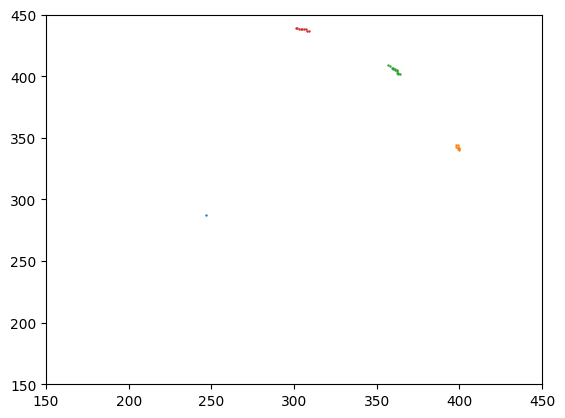

In [104]:
#Clustering
from sklearn.cluster import DBSCAN

coordinates = np.array(coordinates)

# Apply DBSCAN clustering
# eps and min_samples need to be chosen based on your specific data
dbscan = DBSCAN(eps=6, min_samples=1).fit(coordinates)

# Extract labels
labels = dbscan.labels_

# Separate coordinates into arrays for each image
images = {}
for label in set(labels):
    if label != -1:  # Ignore noise points
        images[f"Image_{label}"] = coordinates[labels == label]

# images now contains separate arrays for each detected image
# convert the dictionary images to list
images = list(images.values())

for i in range(0, len(images)):
    plt.scatter(images[i][:,0], images[i][:,1], s=0.5)

'''m=[]
for i in range(0, len(images)):
    mag = len(images[i])/len(circle_coords)
    m.append(mag)
print(f'Magnification: {m}')'''
print(f'Number of pixels: {[np.sum(len(images[i])) for i in range(0, len(images))]}')
plt.xlim(150,450)
plt.ylim(150,450)


In [105]:
# src or img pos?
def src_pos_test(img_guess, lensModel=lensModel):
    alpha_x, alpha_y = lensModel.alpha(img_guess[0], img_guess[1], kwargs_lens)
    return (img_guess[0]-alpha_x, img_guess[1]-alpha_y) #src guess
def diff (img_guess):
    return np.sqrt((src_pos_test(img_guess)[0]-coord[0])**2 + (src_pos_test(img_guess)[1]-coord[1])**2)

247 247 287 287 [247.6500578  287.67612935] 1.9414823959851246e-08
398 400 340 344 [398.73823294 343.94366993] 8.797898272666187e-09
357 364 402 409 [362.9207752  403.55183739] 1.1890230927939303e-09
301 309 437 439 [304.48456704 438.52095801] 3.6497364880736855e-09


"from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver\n\n# specifiy the lens model class to deal with #\nsolver = LensEquationSolver(lensModel)\n\n# solve for image positions provided a lens model and the source position #\nimg_x, img_y = solver.image_position_analytical(coord[0],coord[1], kwargs_lens)\nprint(img_x, img_y)\nplt.scatter(img_x, img_y, c='r', s=100, marker='x')"

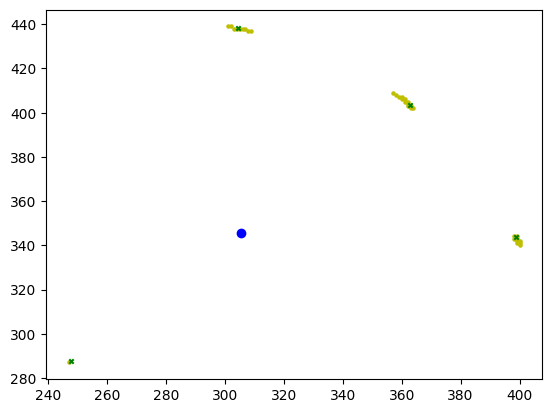

In [119]:
# minimum distance between the source position and the guess source positions deflected by mutiple images
# expect partition of the images and search for 1 sol for 1 image
plt.scatter(coord[0], coord[1], c='b')
plt.scatter([i[0] for i in coordinates], [i[1] for i in coordinates], c='y', s=5)
# find maximum x and y coordinates of the image[i]
for i in range(len(images)):
    x_max, x_min = np.max(images[i][:,0]), np.min(images[i][:,0])
    y_max, y_min = np.max(images[i][:,1]), np.min(images[i][:,1])
    img_guess = np.random.uniform(x_min, x_max), np.random.uniform(y_min, y_max)
    pos = minimize.minimize(diff, img_guess, bounds =[(x_min-1, x_max+1), (y_min-1, y_max+1)], method='L-BFGS-B', tol=1e-8) # the 1 is for wider boundary
    print(x_min, x_max, y_min, y_max, pos.x, diff(pos.x))
    plt.scatter(pos.x[0], pos.x[1], c='g', s=10, marker='x')


'''from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

# specifiy the lens model class to deal with #
solver = LensEquationSolver(lensModel)

# solve for image positions provided a lens model and the source position #
img_x, img_y = solver.image_position_analytical(coord[0],coord[1], kwargs_lens)
print(img_x, img_y)
plt.scatter(img_x, img_y, c='r', s=100, marker='x')'''


32


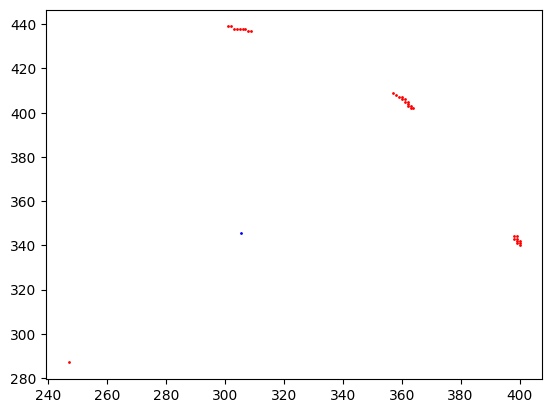

In [107]:
# make a point source
coord = coord

coord_x_r, coord_y_r = coord[0] % 1, coord[1] % 1
y_round, x_round = round(coord[1]), round(coord[0])

# Pre-calculate possible matching rounded values for efficiency
y_possible_rounds = {y_round, y_round - 1} if coord_y_r == 0.5 else {y_round}
x_possible_rounds = {x_round, x_round - 1} if coord_x_r == 0.5 else {x_round}

coordinates = []
n = 0

# Iterate over a pre-defined range, assuming alpha_y_2d and alpha_x_2d are indexed appropriately
for i in range(size):
    for j in range(size):
        ycoord, xcoord = i - alpha_y_2d[i, j], j - alpha_x_2d[i, j]
        if round(ycoord) in y_possible_rounds and round(xcoord) in x_possible_rounds:
            coordinates.append((j, i))  # (x, y)
            n += 1

plt.scatter([i[0] for i in coordinates], [i[1] for i in coordinates], c='r', s=1)
plt.scatter(coord[0], coord[1], c='b', s=1)
print(n)

Number of pixels: [1, 9, 13, 9]


(150.0, 450.0)

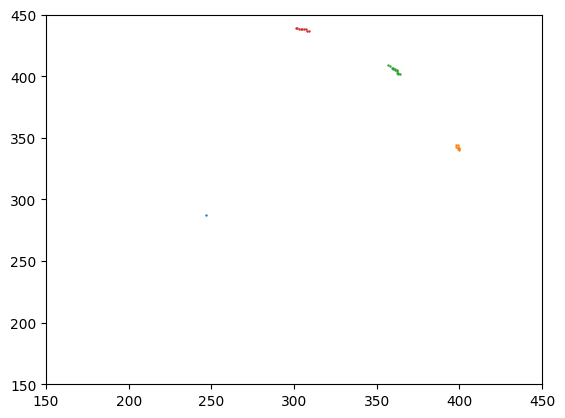

In [100]:
coordinates = np.array(coordinates)

#DBSCAN clustering

dbscan = DBSCAN(eps=6, min_samples=1).fit(coordinates)
labels = dbscan.labels_
images = {}
for label in set(labels):
    if label != -1:  # Ignore noise points
        images[f"Image_{label}"] = coordinates[labels == label]
images = list(images.values())

for i in range(0, len(images)):
    plt.scatter(images[i][:,0], images[i][:,1], s=0.5)
print(f'Number of pixels: {[np.sum(len(images[i])) for i in range(0, len(images))]}')
plt.xlim(150,450)
plt.ylim(150,450)


In [121]:
# interpolate the deflected angle given the image pos
def src_pos_test_interpolate(x,y, alpha_x= alpha_x_2d, alpha_y = alpha_y_2d):  #(x,y) is img_guess
    dx = x - floor(x)
    dy = y - floor(y)
    top_left = np.array([alpha_x[ceil(y), floor(x)], alpha_y[ceil(y), floor(x)]]) #to match (y,x) of alpha grid
    top_right = np.array([alpha_x[ceil(y), ceil(x)], alpha_y[ceil(y), ceil(x)]])
    bottom_left = np.array([alpha_x[floor(y), floor(x)], alpha_y[floor(y), floor(x)]])
    bottom_right = np.array([alpha_x[floor(y), ceil(x)], alpha_y[floor(y), ceil(x)]])
    top = top_left * (1 - dx) + top_right * dx
    bottom = bottom_left * (1 - dx) + bottom_right * dx
    alpha = top * dy + bottom *(1 - dy)
    src_pos = np.array([x-alpha[0], y-alpha[1]])
    return src_pos 
                                             
def diff_interpolate (img_guess):
    return np.sqrt((src_pos_test_interpolate(img_guess[0],img_guess[1])[0]-coord[0])**2 + (src_pos_test_interpolate(img_guess[0],img_guess[1])[1]-coord[1])**2)

247 247 287 287 [247.66161295 287.6879453 ] 2.436535705343935e-08
398 400 340 344 [398.73761353 343.94531227] 1.404960366624881e-08
357 364 402 409 [362.91686641 403.55471969] 1.379908147063866e-08
301 309 437 439 [304.48748949 438.51940557] 1.2727392379991652e-08


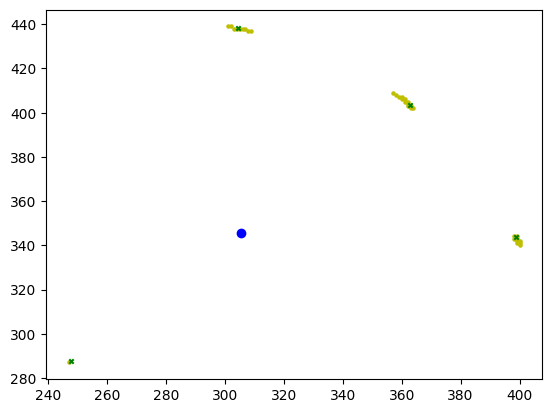

In [140]:
# minimum distance between the source position and the guess source positions deflected by mutiple images
# expect partition of the images and search for 1 sol for 1 image
plt.scatter(coord[0], coord[1], c='b')
plt.scatter([i[0] for i in coordinates], [i[1] for i in coordinates], c='y', s=5)
# find maximum x and y coordinates of the image[i]
for i in range(len(images)):
    x_max, x_min = np.max(images[i][:,0]), np.min(images[i][:,0])
    y_max, y_min = np.max(images[i][:,1]), np.min(images[i][:,1])
    img_guess = np.random.uniform(x_min, x_max), np.random.uniform(y_min, y_max)
    pos = minimize.minimize(diff_interpolate, img_guess, bounds =[(x_min-1, x_max+1), (y_min-1, y_max+1)], method='L-BFGS-B', tol=1e-8) # the 1 is for wider boundary
    print(x_min, x_max, y_min, y_max, pos.x, diff_interpolate(pos.x))
    plt.scatter(pos.x[0], pos.x[1], c='g', s=10, marker='x')

    


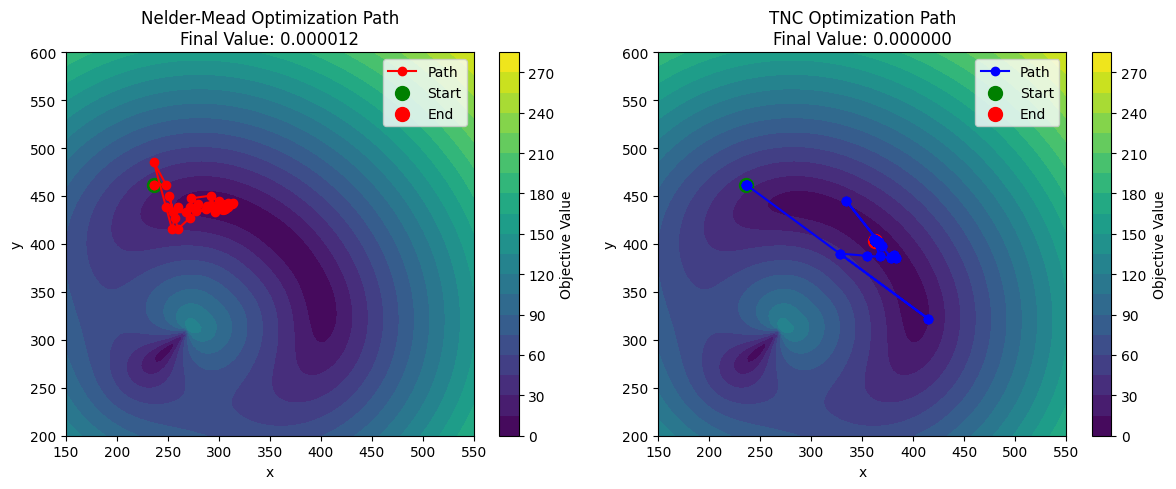

Nelder-Mead result: [304.48743994 438.51942267], value: 1.1545425456506101e-05
TNC result: [362.91686642 403.55471969], value: 3.218089268312487e-09


In [145]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def optimize_with_path(method, x0, bounds):
    path = [x0]
    
    def objective_wrapper(x):
        path.append(x)
        return diff_interpolate(x)
    
    result = minimize(objective_wrapper, x0, method=method, bounds=bounds)
    return result, np.array(path)

# Set up the problem
bounds = [(150, 550), (200, 600)]
x0 = np.random.uniform(bounds[0][0], bounds[0][1]), np.random.uniform(bounds[1][0], bounds[1][1])

# Run optimizations
nelder_mead_result, nelder_mead_path = optimize_with_path('Nelder-Mead', x0, bounds)
tnc_result, tnc_path = optimize_with_path('L-BFGS-B', x0, bounds)

# Create a contour plot of the objective function
x = np.linspace(bounds[0][0], bounds[0][1], 100)
y = np.linspace(bounds[1][0], bounds[1][1], 100)
X, Y = np.meshgrid(x, y)
Z = np.array([diff_interpolate([xi, yi]) for xi, yi in zip(X.ravel(), Y.ravel())]).reshape(X.shape)

# Plot
plt.figure(figsize=(12, 5))

# Nelder-Mead path
plt.subplot(121)
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(label='Objective Value')
plt.plot(nelder_mead_path[:, 0], nelder_mead_path[:, 1], 'ro-', label='Path')
plt.scatter(nelder_mead_path[0, 0], nelder_mead_path[0, 1], c='g', s=100, label='Start')
plt.scatter(nelder_mead_path[-1, 0], nelder_mead_path[-1, 1], c='r', s=100, label='End')
plt.title(f'Nelder-Mead Optimization Path\nFinal Value: {nelder_mead_result.fun:.6f}')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# TNC path
plt.subplot(122)
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(label='Objective Value')
plt.plot(tnc_path[:, 0], tnc_path[:, 1], 'bo-', label='Path')
plt.scatter(tnc_path[0, 0], tnc_path[0, 1], c='g', s=100, label='Start')
plt.scatter(tnc_path[-1, 0], tnc_path[-1, 1], c='r', s=100, label='End')
plt.title(f'TNC Optimization Path\nFinal Value: {tnc_result.fun:.6f}')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.tight_layout()
plt.show()

# Print results
print(f"Nelder-Mead result: {nelder_mead_result.x}, value: {nelder_mead_result.fun}")
print(f"TNC result: {tnc_result.x}, value: {tnc_result.fun}")